In [1]:
!pip install fairseq --user
!pip install ray[tune]


     ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
     - -------------------------------------- 0.4/9.6 MB 8.1 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/9.6 MB 10.4 MB/s eta 0:00:01
     ------ --------------------------------- 1.5/9.6 MB 8.5 MB/s eta 0:00:01
     ---------- ----------------------------- 2.4/9.6 MB 9.6 MB/s eta 0:00:01
     ------------ --------------------------- 3.0/9.6 MB 9.6 MB/s eta 0:00:01
     ----------------- ---------------------- 4.2/9.6 MB 11.1 MB/s eta 0:00:01
     ---------------------- ----------------- 5.3/9.6 MB 12.1 MB/s eta 0:00:01
     ------------------------- -------------- 6.2/9.6 MB 12.8 MB/s eta 0:00:01
     ------------------------------ --------- 7.4/9.6 MB 13.9 MB/s eta 0:00:01
     ------------------------------------- -- 9.0/9.6 MB 15.2 MB/s eta 0:00:01
     ---------------------------------------  9.6/9.6 MB 15.3 MB/s eta 0:00:01
     ---------------------------------------- 9.6/9.6 MB 13.6 MB

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN
from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.KANConvs_MLP import KANC_MLP,KANC_MLP_sin_grid
from architectures_28x28.KANConvs_MLP_2 import KANC_MLP_2,KANC_MLP_sin_grid_2
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from evaluations import *
from hiperparam_tuning import *
torch.manual_seed(42) #Lets set a seed for the weights initialization
torch.use_deterministic_algorithms(True) #Set that torch uses always the same algorithm

c:\Users\alex_\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [4]:
from torch.utils.data import Subset
from collections import Counter
def train_val_split_balanced(train_dataset,proportion = 0.8):
    unique_classes = np.unique(train_dataset.targets.numpy())
    class_counts = Counter(train_dataset.targets.numpy())
    min_class_size = min(class_counts.values())

    balanced_indices = []
    for cls in unique_classes:
        indices_cls = np.where(train_dataset.targets.numpy() == cls)[0]
        np.random.shuffle(indices_cls)
        balanced_indices.extend(indices_cls[:min_class_size])
    np.random.shuffle(balanced_indices)
    train_size = int(proportion* len(balanced_indices))
    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:]
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    return train_subset,val_subset

train_obj ,val_obj = train_val_split_balanced(mnist_train)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Train

In [6]:
model_KANC_MLP= KANC_MLP(device = device)
path = "tony.pt"
search_hiperparams_and_get_final_model(KANC_MLP,True, train_obj, val_obj, test_loader,path,search_grid_combinations = 10 )
#train_model_generic(model_KANC_MLP, train_loader, test_loader,device,epochs = 15)

2024-08-24 19:40:09,979	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-24 19:40:33,354	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-08-24 19:40:33,367	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-08-24 19:40:34 (running for 00:00:00.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/alex_/AppData/Local/Temp/ray/session_2024-08-24_19-40-00_112576_39512/artifacts/2024-08-24_19-40-33/train_tune_2024-08-24_19-40-33/driver_artifacts
Number of trials: 10/10 (10 PENDING)
+------------------------+----------+-------+--------------+--------+----------------+
| Trial name             | status   | loc   |   batch_size |     lr |   weight_decay |
|------------------------+----------+-------+--------------+--------+----------------|
| train_tune_df997_00000 | PENDING  |       |           64 | 0.001  |         0.0001 |
| train_tune_df997_00001 | PENDING  |       |           64 | 1e-05  |         0.0001 |
| train_tune_df997_00002 | PENDING  |       |           64 | 0.0001

(train_tune pid=44584) No module named 'KANLinear'
(train_tune pid=44584) Traceback (most recent call last):
(train_tune pid=44584)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 423, in deserialize_objects
(train_tune pid=44584)     obj = self._deserialize_object(data, metadata, object_ref)
(train_tune pid=44584)           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(train_tune pid=44584)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 280, in _deserialize_object
(train_tune pid=44584)     return self._deserialize_msgpack_data(data, metadata_fields)
(train_tune pid=44584)            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(train_tune pid=44584)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 235, in _deserialize_msgpack_data
(train_tune pid=44584)     python_objects = self._deserialize_pickle5_data(pickle5_data)
(train_tune pid=44584)      

Trial name
train_tune_df997_00000
train_tune_df997_00001


== Status ==
Current time: 2024-08-24 19:41:04 (running for 00:00:30.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/alex_/AppData/Local/Temp/ray/session_2024-08-24_19-40-00_112576_39512/artifacts/2024-08-24_19-40-33/train_tune_2024-08-24_19-40-33/driver_artifacts
Number of trials: 10/10 (1 ERROR, 9 PENDING)
+------------------------+----------+-----------------+--------------+--------+----------------+
| Trial name             | status   | loc             |   batch_size |     lr |   weight_decay |
|------------------------+----------+-----------------+--------------+--------+----------------|
| train_tune_df997_00001 | PENDING  |                 |           64 | 1e-05  |         0.0001 |
| train_tune_df997_00002 | PENDING  |                 |           64 | 0.0001 |         0.0001 |
| train_t

(train_tune pid=39540) c:\Users\alex_\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
(train_tune pid=39540)   _torch_pytree._register_pytree_node(


== Status ==
Current time: 2024-08-24 19:41:40 (running for 00:01:06.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/alex_/AppData/Local/Temp/ray/session_2024-08-24_19-40-00_112576_39512/artifacts/2024-08-24_19-40-33/train_tune_2024-08-24_19-40-33/driver_artifacts
Number of trials: 10/10 (1 ERROR, 8 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+--------------+--------+----------------+
| Trial name             | status   | loc             |   batch_size |     lr |   weight_decay |
|------------------------+----------+-----------------+--------------+--------+----------------|
| train_tune_df997_00001 | RUNNING  | 127.0.0.1:39540 |           64 | 1e-05  |         0.0001 |
| train_tune_df997_00002 | PENDING  |                 |           64 | 0.0001 |         0.0001 

(train_tune pid=39540) No module named 'KANLinear'
(train_tune pid=39540) Traceback (most recent call last):
(train_tune pid=39540)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 423, in deserialize_objects
(train_tune pid=39540)     obj = self._deserialize_object(data, metadata, object_ref)
(train_tune pid=39540)           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(train_tune pid=39540)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 280, in _deserialize_object
(train_tune pid=39540)     return self._deserialize_msgpack_data(data, metadata_fields)
(train_tune pid=39540)            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(train_tune pid=39540)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 235, in _deserialize_msgpack_data
(train_tune pid=39540)     python_objects = self._deserialize_pickle5_data(pickle5_data)
(train_tune pid=39540)      

== Status ==
Current time: 2024-08-24 19:41:45 (running for 00:01:11.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/alex_/AppData/Local/Temp/ray/session_2024-08-24_19-40-00_112576_39512/artifacts/2024-08-24_19-40-33/train_tune_2024-08-24_19-40-33/driver_artifacts
Number of trials: 10/10 (2 ERROR, 8 PENDING)
+------------------------+----------+-----------------+--------------+--------+----------------+
| Trial name             | status   | loc             |   batch_size |     lr |   weight_decay |
|------------------------+----------+-----------------+--------------+--------+----------------|
| train_tune_df997_00002 | PENDING  |                 |           64 | 0.0001 |         0.0001 |
| train_tune_df997_00003 | PENDING  |                 |           64 | 0.0001 |         0.0001 |
| train_t

2024-08-24 19:42:16,334	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-08-24 19:42:16,388	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/alex_/ray_results/train_tune_2024-08-24_19-40-33' in 0.0521s.


== Status ==
Current time: 2024-08-24 19:42:16 (running for 00:01:42.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/alex_/AppData/Local/Temp/ray/session_2024-08-24_19-40-00_112576_39512/artifacts/2024-08-24_19-40-33/train_tune_2024-08-24_19-40-33/driver_artifacts
Number of trials: 10/10 (2 ERROR, 7 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+--------------+--------+----------------+
| Trial name             | status   | loc             |   batch_size |     lr |   weight_decay |
|------------------------+----------+-----------------+--------------+--------+----------------|
| train_tune_df997_00002 | RUNNING  | 127.0.0.1:6860  |           64 | 0.0001 |         0.0001 |
| train_tune_df997_00003 | PENDING  |                 |           64 | 0.0001 |         0.0001 

(train_tune pid=6860) c:\Users\alex_\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
(train_tune pid=6860)   _torch_pytree._register_pytree_node(
(train_tune pid=6860) No module named 'KANLinear'
(train_tune pid=6860) Traceback (most recent call last):
(train_tune pid=6860)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 423, in deserialize_objects
(train_tune pid=6860)     obj = self._deserialize_object(data, metadata, object_ref)
(train_tune pid=6860)           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(train_tune pid=6860)   File "c:\Users\alex_\miniconda3\Lib\site-packages\ray\_private\serialization.py", line 280, in _deserialize_object
(train_tune pid=6860)     return self._deserialize_msgpack_data(data, metadata_fields)
(train_tune pid=6860)            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

AttributeError: 'NoneType' object has no attribute 'config'

In [ ]:
model_KANC_MLP_sin_grid= KANC_MLP_sin_grid(device = device)

train_model_generic(model_KANC_MLP_sin_grid, train_loader, test_loader,device,epochs = 15) #= train_and_test_models(model_KANC_MLP_sin_grid, device, train_loader, test_loader, optimizer_KANC_MLP_sin_grid, criterion_KANC_MLP_sin_grid, epochs=15, scheduler=scheduler_KANC_MLP_sin_grid)


bigger

In [ ]:
model_KANC_MLP_2= KANC_MLP_2(device = device)

train_model_generic(model_KANC_MLP_2, train_loader, test_loader,device,epochs = 15)#train_and_test_models(model_KANC_MLP_2, device, train_loader, test_loader, optimizer_KANC_MLP_2, criterion_KANC_MLP_2, epochs=12, scheduler=scheduler_KANC_MLP_2)


Params start 163951


100%|██████████| 938/938 [01:37<00:00,  9.58it/s]


End of Epoch 1: Train Loss: 0.262386, Test Loss: 0.0016, Accuracy: 96.96%


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


End of Epoch 2: Train Loss: 0.082635, Test Loss: 0.0011, Accuracy: 97.75%


100%|██████████| 938/938 [01:38<00:00,  9.57it/s]


End of Epoch 3: Train Loss: 0.063314, Test Loss: 0.0009, Accuracy: 98.15%


100%|██████████| 938/938 [01:36<00:00,  9.74it/s]


End of Epoch 4: Train Loss: 0.053307, Test Loss: 0.0009, Accuracy: 98.07%


100%|██████████| 938/938 [01:35<00:00,  9.82it/s]


End of Epoch 5: Train Loss: 0.046310, Test Loss: 0.0009, Accuracy: 98.31%


100%|██████████| 938/938 [01:37<00:00,  9.64it/s]


End of Epoch 6: Train Loss: 0.041134, Test Loss: 0.0009, Accuracy: 98.10%


100%|██████████| 938/938 [01:36<00:00,  9.77it/s]


End of Epoch 7: Train Loss: 0.037045, Test Loss: 0.0008, Accuracy: 98.48%


100%|██████████| 938/938 [01:37<00:00,  9.65it/s]


End of Epoch 8: Train Loss: 0.033814, Test Loss: 0.0008, Accuracy: 98.47%


100%|██████████| 938/938 [01:37<00:00,  9.66it/s]


End of Epoch 9: Train Loss: 0.031575, Test Loss: 0.0008, Accuracy: 98.48%


100%|██████████| 938/938 [01:35<00:00,  9.80it/s]


End of Epoch 10: Train Loss: 0.029371, Test Loss: 0.0008, Accuracy: 98.38%


100%|██████████| 938/938 [01:36<00:00,  9.69it/s]


End of Epoch 11: Train Loss: 0.027902, Test Loss: 0.0008, Accuracy: 98.51%


100%|██████████| 938/938 [01:37<00:00,  9.62it/s]


End of Epoch 12: Train Loss: 0.026424, Test Loss: 0.0008, Accuracy: 98.43%


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


End of Epoch 13: Train Loss: 0.025485, Test Loss: 0.0008, Accuracy: 98.50%


100%|██████████| 938/938 [01:42<00:00,  9.12it/s]


End of Epoch 14: Train Loss: 0.024741, Test Loss: 0.0008, Accuracy: 98.58%


100%|██████████| 938/938 [01:46<00:00,  8.80it/s]


End of Epoch 15: Train Loss: 0.023959, Test Loss: 0.0008, Accuracy: 98.53%
Best test accuracy 0.9858
Params End 163951
Total time (min) 26.668998471433333
Train loss [0.2623855763160661, 0.08263530619422606, 0.06331438575558532, 0.053306796473946406, 0.046310216685243724, 0.04113380914559709, 0.03704477982042156, 0.033813933447834406, 0.03157468790332151, 0.029371039215862545, 0.027902078348026275, 0.026423955428721717, 0.025484641470087777, 0.0247410824194415, 0.023958823982600633]
Test loss [0.0016497306480770932, 0.0010551380050193985, 0.0009124033622749266, 0.0009437851681534085, 0.0008516894224187126, 0.0009076509886232089, 0.0007748363095095556, 0.0007977174982370343, 0.0007893659691468202, 0.0008163117614516523, 0.0007772736270846508, 0.0007654489836297216, 0.0007661746806690644, 0.0007789076431068679, 0.0007941848778955318]


In [ ]:
model_KANC_MLP_sin_grid_2= KANC_MLP_sin_grid_2(device = device)
train_model_generic(model_KANC_MLP_sin_grid_2, train_loader, test_loader,device,epochs = 15)

In [ ]:
model_CKAN_BN= CKAN_BN(device)
train_model_generic(model_CKAN_BN, train_loader, test_loader,device,epochs = 15)

Params start 163786


100%|██████████| 938/938 [01:42<00:00,  9.12it/s]


End of Epoch 1: Train Loss: 0.150072, Test Loss: 0.0015, Accuracy: 96.99%


100%|██████████| 938/938 [01:43<00:00,  9.08it/s]


End of Epoch 2: Train Loss: 0.074312, Test Loss: 0.0009, Accuracy: 98.04%


100%|██████████| 938/938 [01:43<00:00,  9.05it/s]


End of Epoch 3: Train Loss: 0.057890, Test Loss: 0.0009, Accuracy: 98.13%


100%|██████████| 938/938 [01:43<00:00,  9.06it/s]


End of Epoch 4: Train Loss: 0.047671, Test Loss: 0.0009, Accuracy: 98.20%


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


End of Epoch 5: Train Loss: 0.040866, Test Loss: 0.0009, Accuracy: 98.02%


100%|██████████| 938/938 [01:34<00:00,  9.88it/s]


End of Epoch 6: Train Loss: 0.034226, Test Loss: 0.0008, Accuracy: 98.53%


100%|██████████| 938/938 [01:32<00:00, 10.09it/s]


End of Epoch 7: Train Loss: 0.029683, Test Loss: 0.0009, Accuracy: 98.27%


100%|██████████| 938/938 [01:32<00:00, 10.12it/s]


End of Epoch 8: Train Loss: 0.025868, Test Loss: 0.0008, Accuracy: 98.46%


100%|██████████| 938/938 [01:36<00:00,  9.77it/s]


End of Epoch 9: Train Loss: 0.022993, Test Loss: 0.0008, Accuracy: 98.34%


100%|██████████| 938/938 [01:33<00:00, 10.02it/s]


End of Epoch 10: Train Loss: 0.020185, Test Loss: 0.0008, Accuracy: 98.47%


100%|██████████| 938/938 [01:35<00:00,  9.86it/s]


End of Epoch 11: Train Loss: 0.018883, Test Loss: 0.0008, Accuracy: 98.46%


100%|██████████| 938/938 [01:34<00:00,  9.91it/s]


End of Epoch 12: Train Loss: 0.017058, Test Loss: 0.0009, Accuracy: 98.35%


100%|██████████| 938/938 [01:32<00:00, 10.15it/s]


End of Epoch 13: Train Loss: 0.016273, Test Loss: 0.0009, Accuracy: 98.45%


100%|██████████| 938/938 [01:33<00:00, 10.06it/s]


End of Epoch 14: Train Loss: 0.015086, Test Loss: 0.0009, Accuracy: 98.42%


100%|██████████| 938/938 [01:33<00:00, 10.01it/s]


End of Epoch 15: Train Loss: 0.014242, Test Loss: 0.0009, Accuracy: 98.50%
Best test accuracy 0.9853
Params End 163786
Total time (min) 26.31781492056667
Train loss [0.1500724454619872, 0.07431203464226328, 0.05788957851982093, 0.04767070152523266, 0.040865523547409716, 0.03422607017422481, 0.0296828736521816, 0.025867811429393994, 0.022993481694671043, 0.020185176018611348, 0.018883234197482356, 0.017057645413348192, 0.016272877247899577, 0.015086347902521812, 0.01424220187865299]
Test loss [0.0014792424543527887, 0.0009470912331191357, 0.00094834809567692, 0.0008722506673228054, 0.0009335491213423666, 0.0007846442277121241, 0.0008673109655566804, 0.0008161048982859939, 0.0008429280760996335, 0.0008435268715360507, 0.0008354808595835493, 0.0008580404857995745, 0.0008561759246893416, 0.0008742454219462161, 0.0008790178761386414]


In [ ]:
model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
train_model_generic(model_KKAN_Convolutional_Network, train_loader, test_loader,device,epochs = 15)

Params start 94875


 13%|█▎        | 126/938 [00:13<01:27,  9.24it/s]

updateo


100%|██████████| 938/938 [01:37<00:00,  9.62it/s]


End of Epoch 1: Train Loss: 0.330100, Test Loss: 0.0014, Accuracy: 97.42%


100%|██████████| 938/938 [01:38<00:00,  9.53it/s]


End of Epoch 2: Train Loss: 0.075470, Test Loss: 0.0010, Accuracy: 98.30%


100%|██████████| 938/938 [01:39<00:00,  9.47it/s]


End of Epoch 3: Train Loss: 0.052122, Test Loss: 0.0008, Accuracy: 98.65%


100%|██████████| 938/938 [01:38<00:00,  9.49it/s]


End of Epoch 4: Train Loss: 0.039746, Test Loss: 0.0007, Accuracy: 98.59%


100%|██████████| 938/938 [01:37<00:00,  9.62it/s]


End of Epoch 5: Train Loss: 0.032119, Test Loss: 0.0007, Accuracy: 98.74%


100%|██████████| 938/938 [01:38<00:00,  9.48it/s]


End of Epoch 6: Train Loss: 0.026683, Test Loss: 0.0006, Accuracy: 98.81%


100%|██████████| 938/938 [01:38<00:00,  9.56it/s]


End of Epoch 7: Train Loss: 0.022571, Test Loss: 0.0006, Accuracy: 98.82%


100%|██████████| 938/938 [01:37<00:00,  9.66it/s]


End of Epoch 8: Train Loss: 0.019905, Test Loss: 0.0006, Accuracy: 98.87%


100%|██████████| 938/938 [01:42<00:00,  9.18it/s]


End of Epoch 9: Train Loss: 0.017752, Test Loss: 0.0006, Accuracy: 98.84%


100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


End of Epoch 10: Train Loss: 0.016168, Test Loss: 0.0006, Accuracy: 98.81%


100%|██████████| 938/938 [01:42<00:00,  9.19it/s]


End of Epoch 11: Train Loss: 0.014922, Test Loss: 0.0006, Accuracy: 98.84%


100%|██████████| 938/938 [01:40<00:00,  9.31it/s]


End of Epoch 12: Train Loss: 0.013985, Test Loss: 0.0006, Accuracy: 98.85%


100%|██████████| 938/938 [01:38<00:00,  9.48it/s]


End of Epoch 13: Train Loss: 0.013253, Test Loss: 0.0006, Accuracy: 98.86%


100%|██████████| 938/938 [01:39<00:00,  9.41it/s]


End of Epoch 14: Train Loss: 0.012673, Test Loss: 0.0006, Accuracy: 98.84%


100%|██████████| 938/938 [01:38<00:00,  9.48it/s]


End of Epoch 15: Train Loss: 0.012234, Test Loss: 0.0006, Accuracy: 98.87%
Best test accuracy 0.9887
Params End 94875
Total time (min) 27.178780476833346
Train loss [0.33010034692654416, 0.07547020248032169, 0.05212189092128071, 0.03974623013677985, 0.03211861098138516, 0.026682927282646235, 0.022570623626023023, 0.01990542326148337, 0.01775202434609281, 0.016168306114897727, 0.01492160857048954, 0.013985375798781957, 0.013253488884268225, 0.012673038044951356, 0.012233513120404467]
Test loss [0.001357885431451723, 0.0009555941508966498, 0.0007865264173422474, 0.0007362464731733781, 0.0007014586364850402, 0.000636259696102934, 0.0006243100014486117, 0.0006063624051603256, 0.000601086219237186, 0.0006053221108624712, 0.0005866366408503382, 0.0005914592620451004, 0.0005831941303709755, 0.0005814928638123092, 0.0005835070460903808]


In [ ]:
model_Convs_and_KAN= NormalConvsKAN()
train_model_generic(model_Convs_and_KAN, train_loader, test_loader,device,epochs = 15)

Params start 94950


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 938/938 [00:24<00:00, 37.85it/s]


End of Epoch 1: Train Loss: 0.258658, Test Loss: 0.0011, Accuracy: 97.81%


100%|██████████| 938/938 [00:23<00:00, 39.99it/s]


End of Epoch 2: Train Loss: 0.067079, Test Loss: 0.0009, Accuracy: 98.29%


100%|██████████| 938/938 [00:23<00:00, 39.92it/s]


End of Epoch 3: Train Loss: 0.049307, Test Loss: 0.0008, Accuracy: 98.35%


100%|██████████| 938/938 [00:24<00:00, 38.38it/s]


End of Epoch 4: Train Loss: 0.039656, Test Loss: 0.0007, Accuracy: 98.58%


100%|██████████| 938/938 [00:22<00:00, 41.99it/s]


End of Epoch 5: Train Loss: 0.032837, Test Loss: 0.0006, Accuracy: 98.62%


100%|██████████| 938/938 [00:23<00:00, 40.39it/s]


End of Epoch 6: Train Loss: 0.028478, Test Loss: 0.0006, Accuracy: 98.66%


100%|██████████| 938/938 [00:23<00:00, 39.96it/s]


End of Epoch 7: Train Loss: 0.024810, Test Loss: 0.0006, Accuracy: 98.66%


100%|██████████| 938/938 [00:22<00:00, 41.16it/s]


End of Epoch 8: Train Loss: 0.021916, Test Loss: 0.0006, Accuracy: 98.65%


100%|██████████| 938/938 [00:22<00:00, 42.27it/s]


End of Epoch 9: Train Loss: 0.019671, Test Loss: 0.0006, Accuracy: 98.71%


100%|██████████| 938/938 [00:23<00:00, 39.82it/s]


End of Epoch 10: Train Loss: 0.018160, Test Loss: 0.0006, Accuracy: 98.68%


100%|██████████| 938/938 [00:36<00:00, 26.00it/s]


End of Epoch 11: Train Loss: 0.016739, Test Loss: 0.0006, Accuracy: 98.71%


100%|██████████| 938/938 [00:22<00:00, 42.11it/s]


End of Epoch 12: Train Loss: 0.015793, Test Loss: 0.0006, Accuracy: 98.73%


100%|██████████| 938/938 [00:22<00:00, 42.29it/s]


End of Epoch 13: Train Loss: 0.014959, Test Loss: 0.0006, Accuracy: 98.72%


100%|██████████| 938/938 [00:23<00:00, 40.14it/s]


End of Epoch 14: Train Loss: 0.014279, Test Loss: 0.0006, Accuracy: 98.75%


100%|██████████| 938/938 [00:23<00:00, 39.41it/s]


End of Epoch 15: Train Loss: 0.013799, Test Loss: 0.0006, Accuracy: 98.72%
Best test accuracy 0.9875
Params End 94950
Total time (min) 6.826655784266666
Train loss [0.25865828202092156, 0.06707867390331207, 0.049306931811621164, 0.039656367015539366, 0.03283700122630029, 0.02847791388658171, 0.024810054077409896, 0.02191593974227034, 0.019670923576200768, 0.01815988411898536, 0.016738510280321323, 0.015793194233038738, 0.014959052570403985, 0.014278986749412028, 0.013798981676372621]
Test loss [0.001136003066156991, 0.0008578613358113216, 0.0008074178027512971, 0.000658730321272742, 0.0006283869789083838, 0.0006367393978631298, 0.0006276543480227702, 0.000600848160595342, 0.0005891159282720764, 0.0005799706179139321, 0.0005792663319123676, 0.0005763103585566568, 0.0005651124168070964, 0.0005650892613492033, 0.0005605370346896962]


In [ ]:
model_ConvNet = ConvNet()
train_model_generic(model_ConvNet, train_loader, test_loader,device,epochs = 15)

Params start 887530


100%|██████████| 938/938 [00:18<00:00, 50.35it/s]


End of Epoch 1: Train Loss: 0.196779, Test Loss: 0.0007, Accuracy: 98.71%


100%|██████████| 938/938 [00:17<00:00, 53.50it/s]


End of Epoch 2: Train Loss: 0.064356, Test Loss: 0.0004, Accuracy: 99.06%


100%|██████████| 938/938 [00:17<00:00, 52.91it/s]


End of Epoch 3: Train Loss: 0.046064, Test Loss: 0.0004, Accuracy: 99.19%


100%|██████████| 938/938 [00:17<00:00, 53.51it/s]


End of Epoch 4: Train Loss: 0.033868, Test Loss: 0.0003, Accuracy: 99.44%


100%|██████████| 938/938 [00:17<00:00, 53.37it/s]


End of Epoch 5: Train Loss: 0.028674, Test Loss: 0.0004, Accuracy: 99.14%


100%|██████████| 938/938 [00:19<00:00, 48.39it/s]


End of Epoch 6: Train Loss: 0.022482, Test Loss: 0.0003, Accuracy: 99.45%


100%|██████████| 938/938 [00:17<00:00, 53.48it/s]


End of Epoch 7: Train Loss: 0.019154, Test Loss: 0.0002, Accuracy: 99.43%


100%|██████████| 938/938 [00:18<00:00, 51.39it/s]


End of Epoch 8: Train Loss: 0.015981, Test Loss: 0.0003, Accuracy: 99.52%


100%|██████████| 938/938 [00:17<00:00, 53.77it/s]


End of Epoch 9: Train Loss: 0.014248, Test Loss: 0.0002, Accuracy: 99.55%


100%|██████████| 938/938 [00:18<00:00, 49.65it/s]


End of Epoch 10: Train Loss: 0.011839, Test Loss: 0.0002, Accuracy: 99.53%


100%|██████████| 938/938 [00:17<00:00, 53.63it/s]


End of Epoch 11: Train Loss: 0.010024, Test Loss: 0.0002, Accuracy: 99.60%


100%|██████████| 938/938 [00:18<00:00, 49.51it/s]


End of Epoch 12: Train Loss: 0.009778, Test Loss: 0.0002, Accuracy: 99.56%


100%|██████████| 938/938 [00:17<00:00, 53.04it/s]


End of Epoch 13: Train Loss: 0.009247, Test Loss: 0.0002, Accuracy: 99.64%


100%|██████████| 938/938 [00:20<00:00, 46.47it/s]


End of Epoch 14: Train Loss: 0.008347, Test Loss: 0.0002, Accuracy: 99.61%


100%|██████████| 938/938 [00:17<00:00, 53.01it/s]


End of Epoch 15: Train Loss: 0.007293, Test Loss: 0.0002, Accuracy: 99.58%
Best test accuracy 0.9964
Params End 887530
Total time (min) 5.206146641266681
Train loss [0.19677938251812727, 0.06435581856518428, 0.046064028557275045, 0.033868110079111266, 0.028673985398308472, 0.02248181775306922, 0.019153992409059187, 0.01598084465335606, 0.014247762665997988, 0.011839016257844958, 0.010024382635338489, 0.009777753585056878, 0.009247102295016227, 0.008346507374233484, 0.007292842624006329]
Test loss [0.0006916595323770025, 0.00041483060231457786, 0.0003933784972416788, 0.00030144584605420734, 0.0004184129879140528, 0.0002713926612223247, 0.00024553985434997685, 0.0002528235834812099, 0.00021675420140895483, 0.00023993041254531775, 0.00023255007757270755, 0.0002462353556357071, 0.00021688614042117074, 0.00022252383797860453, 0.00022760004729153845]


In [ ]:
model_SimpleCNN = SimpleCNN()
train_model_generic(model_SimpleCNN, train_loader, test_loader,device,epochs = 15)

Params start 2740


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 938/938 [00:16<00:00, 57.31it/s]


End of Epoch 1: Train Loss: 0.450838, Test Loss: 0.0030, Accuracy: 94.35%


100%|██████████| 938/938 [00:15<00:00, 60.10it/s]


End of Epoch 2: Train Loss: 0.170239, Test Loss: 0.0022, Accuracy: 95.69%


100%|██████████| 938/938 [00:15<00:00, 59.69it/s]


End of Epoch 3: Train Loss: 0.131919, Test Loss: 0.0017, Accuracy: 96.65%


100%|██████████| 938/938 [00:15<00:00, 60.42it/s]


End of Epoch 4: Train Loss: 0.112356, Test Loss: 0.0015, Accuracy: 96.78%


100%|██████████| 938/938 [00:16<00:00, 58.24it/s]


End of Epoch 5: Train Loss: 0.100267, Test Loss: 0.0014, Accuracy: 97.07%


100%|██████████| 938/938 [00:15<00:00, 60.58it/s]


End of Epoch 6: Train Loss: 0.092474, Test Loss: 0.0014, Accuracy: 97.18%


100%|██████████| 938/938 [00:16<00:00, 56.59it/s]


End of Epoch 7: Train Loss: 0.087431, Test Loss: 0.0013, Accuracy: 97.35%


100%|██████████| 938/938 [00:16<00:00, 58.61it/s]


End of Epoch 8: Train Loss: 0.083355, Test Loss: 0.0013, Accuracy: 97.35%


100%|██████████| 938/938 [00:15<00:00, 60.83it/s]


End of Epoch 9: Train Loss: 0.080251, Test Loss: 0.0012, Accuracy: 97.48%


100%|██████████| 938/938 [00:15<00:00, 60.51it/s]


End of Epoch 10: Train Loss: 0.077930, Test Loss: 0.0012, Accuracy: 97.52%


100%|██████████| 938/938 [00:15<00:00, 58.98it/s]


End of Epoch 11: Train Loss: 0.076219, Test Loss: 0.0012, Accuracy: 97.55%


100%|██████████| 938/938 [00:15<00:00, 59.98it/s]


End of Epoch 12: Train Loss: 0.074758, Test Loss: 0.0012, Accuracy: 97.53%


100%|██████████| 938/938 [00:15<00:00, 60.90it/s]


End of Epoch 13: Train Loss: 0.073678, Test Loss: 0.0012, Accuracy: 97.59%


100%|██████████| 938/938 [00:15<00:00, 60.03it/s]


End of Epoch 14: Train Loss: 0.072907, Test Loss: 0.0012, Accuracy: 97.58%


100%|██████████| 938/938 [00:17<00:00, 54.10it/s]


End of Epoch 15: Train Loss: 0.072194, Test Loss: 0.0012, Accuracy: 97.53%
Best test accuracy 0.9759
Params End 2740
Total time (min) 4.584045981866681
Train loss [0.45083753166517726, 0.17023897208749994, 0.13191911752726923, 0.11235636075251679, 0.10026695002376763, 0.09247436469097112, 0.08743112802064654, 0.08335458845156295, 0.08025070602969844, 0.07792979276238649, 0.07621912705475714, 0.07475815193384075, 0.07367797357105672, 0.07290654753827289, 0.07219398733171851]
Test loss [0.002974911522679031, 0.002150677664484829, 0.0017380479232408106, 0.0015399300929508173, 0.0014233361486403738, 0.0013683702689420898, 0.0013109069409838411, 0.001262131613312522, 0.0012203588125295937, 0.0012028662568656727, 0.0011760280184214935, 0.0011820364425657317, 0.001163983453856781, 0.0011705645767593523, 0.0011667400987673319]


In [ ]:
model_SimpleCNN_2 = SimpleCNN_2()
train_model_generic(model_SimpleCNN_2, train_loader, test_loader,device,epochs = 15)

Params start 157030


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 938/938 [00:15<00:00, 59.61it/s]


End of Epoch 1: Train Loss: 0.215307, Test Loss: 0.0011, Accuracy: 97.76%


100%|██████████| 938/938 [00:16<00:00, 58.53it/s]


End of Epoch 2: Train Loss: 0.061549, Test Loss: 0.0008, Accuracy: 98.39%


100%|██████████| 938/938 [00:16<00:00, 57.32it/s]


End of Epoch 3: Train Loss: 0.042772, Test Loss: 0.0006, Accuracy: 98.79%


100%|██████████| 938/938 [00:15<00:00, 59.36it/s]


End of Epoch 4: Train Loss: 0.032295, Test Loss: 0.0006, Accuracy: 98.78%


100%|██████████| 938/938 [00:15<00:00, 59.00it/s]


End of Epoch 5: Train Loss: 0.024384, Test Loss: 0.0005, Accuracy: 98.88%


100%|██████████| 938/938 [00:16<00:00, 57.07it/s]


End of Epoch 6: Train Loss: 0.019607, Test Loss: 0.0005, Accuracy: 99.10%


100%|██████████| 938/938 [00:17<00:00, 53.95it/s]


End of Epoch 7: Train Loss: 0.015611, Test Loss: 0.0005, Accuracy: 98.96%


100%|██████████| 938/938 [00:16<00:00, 57.89it/s]


End of Epoch 8: Train Loss: 0.012567, Test Loss: 0.0005, Accuracy: 98.93%


100%|██████████| 938/938 [00:15<00:00, 58.83it/s]


End of Epoch 9: Train Loss: 0.010368, Test Loss: 0.0004, Accuracy: 99.07%


100%|██████████| 938/938 [00:15<00:00, 58.87it/s]


End of Epoch 10: Train Loss: 0.008736, Test Loss: 0.0005, Accuracy: 99.10%


100%|██████████| 938/938 [00:15<00:00, 59.43it/s]


End of Epoch 11: Train Loss: 0.007435, Test Loss: 0.0005, Accuracy: 99.04%


100%|██████████| 938/938 [00:16<00:00, 58.57it/s]


End of Epoch 12: Train Loss: 0.006414, Test Loss: 0.0005, Accuracy: 99.05%


100%|██████████| 938/938 [00:15<00:00, 59.30it/s]


End of Epoch 13: Train Loss: 0.005754, Test Loss: 0.0004, Accuracy: 99.12%


100%|██████████| 938/938 [00:15<00:00, 60.11it/s]


End of Epoch 14: Train Loss: 0.005162, Test Loss: 0.0004, Accuracy: 99.09%


100%|██████████| 938/938 [00:17<00:00, 52.37it/s]


End of Epoch 15: Train Loss: 0.004763, Test Loss: 0.0005, Accuracy: 99.11%
Best test accuracy 0.9912
Params End 157030
Total time (min) 4.665583197149999
Train loss [0.2153065754964487, 0.06154870330097913, 0.04277152994916693, 0.03229521986045964, 0.02438374906954572, 0.01960699405209452, 0.015611220584532097, 0.01256696432319431, 0.010368083908052522, 0.008736183194642998, 0.007435160725497763, 0.0064139748471727315, 0.0057541939939348904, 0.0051615699003513555, 0.004763153930038018]
Test loss [0.0011142414663452655, 0.0007549954134767177, 0.000575287754740566, 0.0005782015048127505, 0.000520505543595209, 0.0004528160790086986, 0.00048355162371808546, 0.0005273939783448441, 0.00044758266667295173, 0.0004589002136615818, 0.00047815021515457373, 0.0004601389547351573, 0.00044776597435047734, 0.00044503886868596965, 0.000458002571860834]


In [ ]:
model_SimpleLinear = SimpleLinear()
train_model_generic(model_SimpleLinear, train_loader, test_loader,device,epochs = 15)

Params start 7850


100%|██████████| 938/938 [00:14<00:00, 62.86it/s]


End of Epoch 1: Train Loss: 0.466882, Test Loss: 0.0052, Accuracy: 90.50%


100%|██████████| 938/938 [00:14<00:00, 63.08it/s]


End of Epoch 2: Train Loss: 0.324653, Test Loss: 0.0048, Accuracy: 91.39%


100%|██████████| 938/938 [00:15<00:00, 62.14it/s]


End of Epoch 3: Train Loss: 0.305680, Test Loss: 0.0046, Accuracy: 91.34%


100%|██████████| 938/938 [00:15<00:00, 61.21it/s]


End of Epoch 4: Train Loss: 0.294332, Test Loss: 0.0044, Accuracy: 92.08%


100%|██████████| 938/938 [00:14<00:00, 63.00it/s]


End of Epoch 5: Train Loss: 0.287557, Test Loss: 0.0044, Accuracy: 91.95%


100%|██████████| 938/938 [00:15<00:00, 60.53it/s]


End of Epoch 6: Train Loss: 0.282916, Test Loss: 0.0043, Accuracy: 92.14%


100%|██████████| 938/938 [00:16<00:00, 58.53it/s]


End of Epoch 7: Train Loss: 0.279618, Test Loss: 0.0043, Accuracy: 92.08%


100%|██████████| 938/938 [00:15<00:00, 62.22it/s]


End of Epoch 8: Train Loss: 0.276311, Test Loss: 0.0043, Accuracy: 92.06%


100%|██████████| 938/938 [00:16<00:00, 57.99it/s]


End of Epoch 9: Train Loss: 0.273946, Test Loss: 0.0043, Accuracy: 92.15%


100%|██████████| 938/938 [00:14<00:00, 63.59it/s]


End of Epoch 10: Train Loss: 0.272417, Test Loss: 0.0043, Accuracy: 92.11%


100%|██████████| 938/938 [00:15<00:00, 60.87it/s]


End of Epoch 11: Train Loss: 0.270729, Test Loss: 0.0043, Accuracy: 92.32%


100%|██████████| 938/938 [00:14<00:00, 63.04it/s]


End of Epoch 12: Train Loss: 0.269759, Test Loss: 0.0043, Accuracy: 92.34%


100%|██████████| 938/938 [00:14<00:00, 63.37it/s]


End of Epoch 13: Train Loss: 0.268956, Test Loss: 0.0043, Accuracy: 92.19%


100%|██████████| 938/938 [00:14<00:00, 62.60it/s]


End of Epoch 14: Train Loss: 0.268127, Test Loss: 0.0043, Accuracy: 92.14%


100%|██████████| 938/938 [00:15<00:00, 60.80it/s]


End of Epoch 15: Train Loss: 0.267893, Test Loss: 0.0043, Accuracy: 92.30%
Best test accuracy 0.9234
Params End 7850
Total time (min) 4.402668502883338
Train loss [0.4668815539303873, 0.32465313249496003, 0.3056797910251343, 0.2943319136511161, 0.2875569615521029, 0.2829159746276163, 0.2796182502577427, 0.2763108005290474, 0.27394571668033535, 0.2724170165497865, 0.2707292076541798, 0.26975869315106477, 0.2689561633857837, 0.2681270532889852, 0.2678930122397348]
Test loss [0.005189526786655188, 0.004774006062187254, 0.004594814964570105, 0.0044096375321038064, 0.004385773884877563, 0.0043475342146120964, 0.004346767445001751, 0.004340619095042348, 0.0043092621291056276, 0.004304934379179031, 0.004306505561806262, 0.004298457767441869, 0.00428695142166689, 0.004284266061428934, 0.004275586603954435]


# Evaluate models

In [ ]:
ls

Convolutional-KANs/  data/  drive/  sample_data/


In [ ]:
%mv Convolutional-KANs Convolutional_KANs

In [ ]:
device

device(type='cuda')

In [ ]:
path = "/content/drive/MyDrive/KANs/models"
def join_path(name,pa):
  print(os.path.join(pa,name+".pt"))
  return os.path.join(pa,name+".pt")
model_KANC_MLP = torch.load(join_path("KAN Conv Grid updated & 1 Layer MLP",path), map_location=torch.device(device))
model_KANC_MLP_sin_grid =torch.load(join_path("KAN Conv & 1 Layer MLP",path), map_location=torch.device(device))
model_KANC_MLP_2 = torch.load(join_path("KAN Conv Grid updated & 2 Layer MLP",path), map_location=torch.device(device))
model_KANC_MLP_sin_grid_2 = torch.load(join_path("KAN Conv & 2 Layer MLP",path), map_location=torch.device(device))
model_CKAN_BN = torch.load(join_path("KAN Conv BN & 2 Layer MLP",path), map_location=torch.device(device))

model_KKAN_Convolutional_Network= torch.load(join_path("KKAN (Small)",path), map_location=torch.device(device))
model_ConvNet= torch.load(join_path("CNN (Big)",path), map_location=torch.device(device))
model_SimpleCNN= torch.load(join_path( "CNN (Small)",path), map_location=torch.device(device))
model_SimpleCNN_2= torch.load(join_path("CNN (Medium)",path), map_location=torch.device(device))
model_SimpleLinear= torch.load(join_path("1 Layer MLP",path), map_location=torch.device(device))
model_Convs_and_KAN= torch.load(join_path("Conv & KAN",path), map_location=torch.device(device))


/content/drive/MyDrive/KANs/models/KAN Conv Grid updated & 1 Layer MLP.pt
/content/drive/MyDrive/KANs/models/KAN Conv & 1 Layer MLP.pt
/content/drive/MyDrive/KANs/models/KAN Conv Grid updated & 2 Layer MLP.pt
/content/drive/MyDrive/KANs/models/KAN Conv & 2 Layer MLP.pt
/content/drive/MyDrive/KANs/models/KAN Conv BN & 2 Layer MLP.pt
/content/drive/MyDrive/KANs/models/KKAN (Small).pt
/content/drive/MyDrive/KANs/models/CNN (Big).pt
/content/drive/MyDrive/KANs/models/CNN (Small).pt
/content/drive/MyDrive/KANs/models/CNN (Medium).pt
/content/drive/MyDrive/KANs/models/1 Layer MLP.pt
/content/drive/MyDrive/KANs/models/Conv & KAN.pt


In [ ]:
print(model_SimpleCNN.name)
print(model_SimpleCNN_2.name)
print(model_ConvNet.name)

CNN (Small)
CNN (Medium)
CNN (Big)


In [ ]:
models = [model_Convs_and_KAN, model_KANC_MLP ,model_KANC_MLP_2,model_CKAN_BN,
          model_KKAN_Convolutional_Network,model_ConvNet,model_SimpleCNN,model_SimpleCNN_2,model_SimpleLinear]

models = [model_Convs_and_KAN, model_KANC_MLP ,model_KANC_MLP_2,model_CKAN_BN,
          model_KKAN_Convolutional_Network,model_SimpleCNN,model_SimpleCNN_2,model_SimpleLinear]

In [ ]:
train_loss_Conv_KAN = model_Convs_and_KAN.train_losses

test_loss_Conv_KAN =  model_Convs_and_KAN.test_losses

In [ ]:
print(train_loss_Conv_KAN)
print(test_loss_Conv_KAN)


[0.25865828202092156, 0.06707867390331207, 0.049306931811621164, 0.039656367015539366, 0.03283700122630029, 0.02847791388658171, 0.024810054077409896, 0.02191593974227034, 0.019670923576200768, 0.01815988411898536, 0.016738510280321323, 0.015793194233038738, 0.014959052570403985, 0.014278986749412028, 0.013798981676372621]
[0.001136003066156991, 0.0008578613358113216, 0.0008074178027512971, 0.000658730321272742, 0.0006283869789083838, 0.0006367393978631298, 0.0006276543480227702, 0.000600848160595342, 0.0005891159282720764, 0.0005799706179139321, 0.0005792663319123676, 0.0005763103585566568, 0.0005651124168070964, 0.0005650892613492033, 0.0005605370346896962]


In [ ]:
criterion = nn.CrossEntropyLoss()


In [ ]:
%cd Convolutional_KANs/
!git pull
from evaluations import *

%cd ..

/content/Convolutional_KANs
Already up to date.
/content


In [ ]:
train_loss_KANC_MLP = [0.33935674588217823,
  0.0942687428286319,
  0.07197279591850046,
  0.06847678308538012,
  0.05955250870172324,
  0.05417216954299056,
  0.051098475226763085,
  0.04846410318275294,
  0.04647071218601605,
  0.04489730181235042,
  0.04380074222368607,
  0.042873787013059265,
  0.04205073245085164,
  0.041650337677921596,
  0.04109629193608309]

test_loss_KANC_MLP = [0.001697738205967471,
  0.0011757755266386084,
  0.0009898879855289124,
  0.0009994714320928325,
  0.0009017263221903705,
  0.0008854410335523426,
  0.0008065840090697747,
  0.0008300244908125024,
  0.0007792393520590849,
  0.0007758027418865822,
  0.0007766278183560643,
  0.000768101255075453,
  0.0007607919593909173,
  0.000765979799492925,
  0.0007639804949954851]

train_loss_KANC_MLP_2=[0.21897231480146426,
  0.07353251453624098,
  0.05721937116870442,
  0.047878696132319244,
  0.04150438564655774,
  0.0366078559656132,
  0.03311703953255804,
  0.030196960272012043,
  0.027638596368952096,
  0.025961983091717183,
  0.02425185625298894,
  0.023127057526728757,
  0.022238810120501926,
  0.021531728393705273,
  0.020969354467974582]

test_loss_KANC_MLP_2=[0.0012612488556886091,
  0.0009558329595427495,
  0.0009132928017614177,
  0.0007507752088451525,
  0.0007176788398275675,
  0.0006705681244675361,
  0.0007046450834299322,
  0.0006859115182596725,
  0.0006730625281386892,
  0.0006581980004859361,
  0.00065217373815467,
  0.0006518551567376562,
  0.0006583203260815935,
  0.0006584684147856024,
  0.0006532971342006932]

train_loss_CKAN_BN = [0.1454220675468159,
  0.06977446501052428,
  0.05467932953944565,
  0.04516425674015692,
  0.03924263060787447,
  0.0326767945529343,
  0.02824860371321987,
  0.024938190037771604,
  0.021705107057874432,
  0.01972180532462121,
  0.017632725264011165,
  0.01651676905044575,
  0.015244268209886065,
  0.014398638652289162,
  0.013539855513333985]

test_loss_CKAN_BN = [0.0012777296436193865,
  0.0009903840879400378,
  0.0008397236175260332,
  0.0009113362471929576,
  0.0009358388909924542,
  0.0008627519926922105,
  0.0007917359379345726,
  0.0007634779685409739,
  0.0007966364572730526,
  0.0007481639421594081,
  0.0007896610071511531,
  0.0008326483950073453,
  0.0007935179021555086,
  0.0007981807186223705,
  0.0008147037002936485]

train_loss_KKAN_Convolutional_Network = [0.29593345961734047,
  0.06703833738979358,
  0.045814201937241755,
  0.03472468644149228,
  0.02729775428524745,
  0.022482037726940633,
  0.019001716354202582,
  0.016357068117630522,
  0.014498275348237518,
  0.013094616639090262,
  0.011966808757030848,
  0.011163318441730978,
  0.010524594565609724,
  0.009998534695552622,
  0.009628105908818444]

test_loss_KKAN_Convolutional_Network = [0.0011849331812467427,
  0.0008751846319239121,
  0.0007065556886198465,
  0.0006651774811791256,
  0.0006106808413955151,
  0.0005910350679376279,
  0.0005753468407914624,
  0.0005746232837322168,
  0.0005581805207912112,
  0.0005535830790628098,
  0.0005543200286178035,
  0.0005455328260803072,
  0.0005406708003203675,
  0.0005392164097072964,
  0.000543378471196047]

train_loss_ConvNet = [0.19379471953206662,
  0.06455506513546556,
  0.0478643131984295,
  0.03727007834338841,
  0.02920598080168902,
  0.023823515148367672,
  0.019825003386327703,
  0.01665158382724091,
  0.0149261552344977,
  0.013298576379093147,
  0.011078102065825048,
  0.01106280538906038,
  0.009832706688020462,
  0.009176246020339169,
  0.008077317574399886]

test_loss_ConvNet = [0.0006172624262791942,
  0.0004986049612256465,
  0.00029875820723991635,
  0.0003146402778787433,
  0.00029350810720150803,
  0.0002944076888647146,
  0.0002737197645238375,
  0.00023522360299459385,
  0.00024192878297724292,
  0.00024276122564490877,
  0.0002392799811821666,
  0.00023753235846703946,
  0.00023967942000596015,
  0.0002441088602063266,
  0.0002475420888528971]

train_loss_SimpleCNN = [0.4827697675730755,
  0.16258251108427738,
  0.12528885773389037,
  0.10987440913296076,
  0.09947605180327715,
  0.09353382859541885,
  0.08921899093386493,
  0.08578226174007474,
  0.08321647276319484,
  0.08139398432910633,
  0.07991313835882,
  0.07843345607906929,
  0.0777096628416965,
  0.07700086347580051,
  0.07639722884304996]

test_loss_SimpleCNN = [0.002865686759725213,
  0.0019234731859527527,
  0.0016345450958120636,
  0.0014748451225692406,
  0.0012684928980306721,
  0.0012441728233592586,
  0.0011984232717193663,
  0.0011801399301039055,
  0.0011480779777979478,
  0.0011214048394700513,
  0.0011083945760969073,
  0.0010890323044732214,
  0.0010828427439264487,
  0.0011008486401056872,
  0.0010745813698973506]

train_loss_SimpleCNN_2 = [0.21117990984241847,
  0.05991160728658901,
  0.0415561657774,
  0.030429686001911045,
  0.02336589108189709,
  0.017997318578826665,
  0.014250236912304709,
  0.011287525106904478,
  0.008998478992184292,
  0.007357852079045858,
  0.006219709534491721,
  0.00541637867014881,
  0.004725116936954251,
  0.004297926528770423,
  0.0038061361329828347]

test_loss_SimpleCNN_2 = [0.0011171785625920165,
  0.000848297135849134,
  0.0005197482292765926,
  0.0005423031548663857,
  0.0004732234713173966,
  0.00044309434893111756,
  0.0004348146197347887,
  0.000394797144939821,
  0.00042125085809871054,
  0.00046374585712596856,
  0.0004329789427749006,
  0.00042491928045982377,
  0.0004180356933119242,
  0.00042474594459181956,
  0.0004305196293459744]

train_loss_SimpleLinear = [0.4674932952088588,
  0.32431868392267205,
  0.3048694340198406,
  0.294418965662911,
  0.2879594070618468,
  0.2827838738558135,
  0.27879312542328705,
  0.27654710583595327,
  0.27456822490164723,
  0.2718526973073353,
  0.2704906691270851,
  0.27014333968843096,
  0.26892970593721627,
  0.2680446036271195,
  0.2674915510525645],

test_loss_SimpleLinear = [0.005068106623366475,
  0.004644092352502048,
  0.00451062976103276,
  0.004370839706156403,
  0.004394953608885407,
  0.004365261895209551,
  0.004440076595917344,
  0.004351968009211123,
  0.004322553045488894,
  0.00428967675184831,
  0.0043442101340740915,
  0.004279218317288906,
  0.004296377332881093,
  0.0042906446773558855,
  0.004280940962117165]

In [ ]:
all_train_loss= [train_loss_Conv_KAN, train_loss_KANC_MLP, train_loss_KANC_MLP_2, train_loss_CKAN_BN, train_loss_KKAN_Convolutional_Network, train_loss_ConvNet, train_loss_SimpleCNN, train_loss_SimpleCNN_2, train_loss_SimpleLinear]
all_test_loss= [test_loss_Conv_KAN, test_loss_KANC_MLP, test_loss_KANC_MLP_2, test_loss_CKAN_BN, test_loss_KKAN_Convolutional_Network, test_loss_ConvNet, test_loss_SimpleCNN, test_loss_SimpleCNN_2, test_loss_SimpleLinear]

all_train_loss= [train_loss_Conv_KAN, train_loss_KANC_MLP, train_loss_KANC_MLP_2, train_loss_CKAN_BN, train_loss_KKAN_Convolutional_Network, train_loss_SimpleCNN, train_loss_SimpleCNN_2, train_loss_SimpleLinear]
all_test_loss= [test_loss_Conv_KAN, test_loss_KANC_MLP, test_loss_KANC_MLP_2, test_loss_CKAN_BN, test_loss_KKAN_Convolutional_Network, test_loss_SimpleCNN, test_loss_SimpleCNN_2, test_loss_SimpleLinear]

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def final_plots(models,test_loader,criterion,device,use_time = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    accs = []
    precisions = []
    recalls = []
    f1s = []
    params_counts = []
    times = []
    contar=0
    color_map = plt.get_cmap('tab10')(np.linspace(0, 1, len(models)))  # Definir el mapa de colores

    for i, model in enumerate(models):
        print(model.name)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        model_loss = all_test_loss[i]  # Get the correct sublist for the current model
        for epoch in range(len(model_loss)):
            if epoch == 0:
                ax1.plot(range(len(model_loss)), model_loss, label=model.name, color=color_map[i])
            # else:
            #     ax1.plot(range(len(model_loss)), model_loss, color=color_map[i])
        ax2.scatter(count_parameters(model), accuracy, label=model.name, color=color_map[i])

        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        print(precision)
        params_counts.append(count_parameters(model))
        if use_time :
            times.append(model.training_time)
        else:
            times.append(np.nan)
        contar+=1

    ax1.set_title('Loss Test vs Epochs',fontsize = 12)
    ax1.set_xlabel('Epochs',fontsize = 10)
    ax1.set_ylabel('Loss',fontsize = 10)
    # ax1.legend(fontsize = 20)
    ax1.grid(True)
    ax2.set_title('Number of Parameters vs Accuracy',fontsize = 12)
    ax2.set_xlabel('Number of Parameters',fontsize = 10)
    ax2.set_ylabel('Accuracy (%)',fontsize = 10)
    ax2.legend(fontsize = 10)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
        # Creación del DataFrame
    df = pd.DataFrame({
        "Test Accuracy": accs,
        "Test Precision": precisions,
        "Test Recall": recalls,
        "Test F1 Score": f1s,
        "Number of Parameters": params_counts,
        "Time":times
    }, index=[m.name for m in models])

    df.to_csv('experiment_28x28.csv', index=False)

    # Aplicando el estilo
    df_styled = df.style.apply(highlight_max, subset=df.columns[:], axis=0).format('{:.3f}')
    return df_styled

def final_plots_2(models, test_loader, criterion, device, use_time=False):
    fig = plt.figure(figsize=(8, 5))
    accs = []
    params_counts = []
    color_map = plt.get_cmap('tab10')(np.linspace(0, 1, len(models)))  # Definir el mapa de colores

    for i, model in enumerate(models):
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        plt.scatter(count_parameters(model), accuracy, color=color_map[i], label=model.name)  # Usar colores del mapa
        accs.append(accuracy)
        params_counts.append(count_parameters(model))

    # Establecer el tamaño de las fuentes
    plt.xlabel('Number of Parameters', fontsize=10)
    plt.ylabel('Accuracy (%)', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return accs

In [ ]:
all_test_loss[0]

[0.001136003066156991,
 0.0008578613358113216,
 0.0008074178027512971,
 0.000658730321272742,
 0.0006283869789083838,
 0.0006367393978631298,
 0.0006276543480227702,
 0.000600848160595342,
 0.0005891159282720764,
 0.0005799706179139321,
 0.0005792663319123676,
 0.0005763103585566568,
 0.0005651124168070964,
 0.0005650892613492033,
 0.0005605370346896962]

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def final_plots(models,test_loader,criterion,device,use_time = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    accs = []
    precisions = []
    recalls = []
    f1s = []
    params_counts = []
    times = []
    contar=0
    todopa=[]
    color_map = plt.get_cmap('tab10')(np.linspace(0, 1, len(models)))  # Definir el mapa de colores

    for i, model in enumerate(models):
        print(model.name)
        names = [
            "Conv & KAN", "KAN Conv & 1 Layer MLP", "KAN Conv & 2 Layer MLP",
            "KAN Conv BN & 2 Layer MLP", "KKAN (Small)", "CNN (Big)", "CNN (Small)", "CNN (Medium)",
            "1 Layer MLP"
        ]
        names = [
            "Conv & KAN", "KAN Conv & 1 Layer MLP", "KAN Conv & 2 Layer MLP",
            "KAN Conv BN & 2 Layer MLP", "KKAN (Small)", "CNN (Small)", "CNN (Medium)",
            "1 Layer MLP"
        ]
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        model_loss = all_test_loss[i]
        x = range(len(model_loss))
        ax1.plot(x, model_loss, label=names[i], color=color_map[i])
            # else:
            #     ax1.plot(range(len(model_loss)), model_loss, color=color_map[i])
        ax2.scatter(count_parameters(model), accuracy, label=model.name, color=color_map[i])

        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        print(precision)
        params_counts.append(count_parameters(model))
        if use_time :
            times.append(model.training_time)
        else:
            times.append(np.nan)
        contar+=1

    ax1.set_title('Loss Test vs Epochs',fontsize = 12)
    ax1.set_xlabel('Epochs',fontsize = 10)
    ax1.set_ylabel('Loss',fontsize = 10)
    ax1.legend(fontsize = 10,loc='upper right')
    ax1.grid(True)
    ax2.set_title('Number of Parameters vs Accuracy',fontsize = 12)
    ax2.set_xlabel('Number of Parameters',fontsize = 10)
    ax2.set_ylabel('Accuracy (%)',fontsize = 10)
    ax2.legend(fontsize = 10)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
        # Creación del DataFrame
    df = pd.DataFrame({
        "Test Accuracy": accs,
        "Test Precision": precisions,
        "Test Recall": recalls,
        "Test F1 Score": f1s,
        "Number of Parameters": params_counts,
        "Time":times
    }, index=[m.name for m in models])

    df.to_csv('experiment_28x28.csv', index=False)

    # Aplicando el estilo
    df_styled = df.style.apply(highlight_max, subset=df.columns[:], axis=0).format('{:.4f}')
    return df_styled

In [ ]:
test_loss, accuracy, precision, recall, f1 = test(model_Convs_and_KAN, device, test_loader, criterion)
accuracy

0.9875

In [ ]:
models[8]=model_Convs_and_KAN

Conv & KAN
0.9874772505196179
KAN Conv Grid updated & 1 Layer MLP
0.9854118179829563
KAN Conv Grid updated & 2 Layer MLP
0.9858060763207881
KAN Conv BN & 2 Layer MLP
0.9853667933607669
KKAN (Small)
0.9887540752092745
CNN (Small)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0.9759952949413006
CNN (Medium)
0.9911015682432739
1 Layer MLP
0.9222182249044995


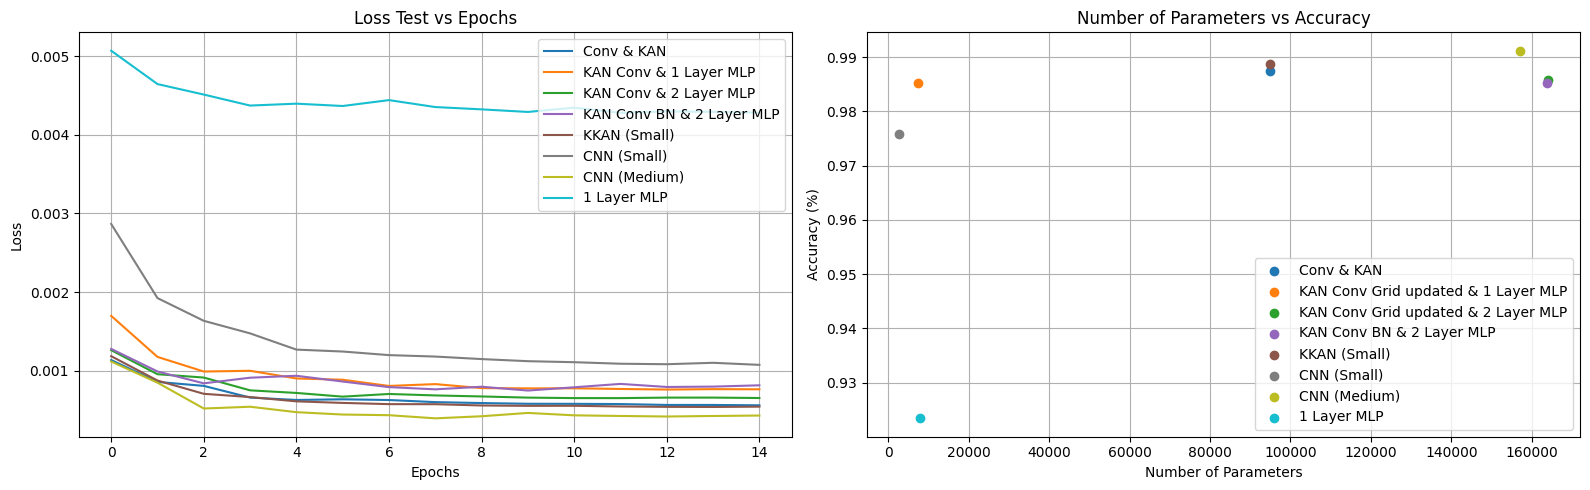

In [ ]:
accs = final_plots(models,test_loader,criterion,device, use_time=True)

In [ ]:
accs

,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Number of Parameters,Time
Conv & KAN,0.9875,0.9875,0.9874,0.9874,94950.0000,0.4551
KAN Conv Grid updated & 1 Layer MLP,0.9853,0.9854,0.9852,0.9853,7385.0000,1.7867
KAN Conv Grid updated & 2 Layer MLP,0.9858,0.9858,0.9857,0.9858,163951.0000,1.7779
KAN Conv BN & 2 Layer MLP,0.9853,0.9854,0.9852,0.9853,163786.0000,1.7545
KKAN (Small),0.9887,0.9888,0.9887,0.9887,94875.0000,1.8119
CNN (Big),0.9964,0.9964,0.9963,0.9964,887530.0000,0.3471
CNN (Small),0.9759,0.9760,0.9758,0.9759,2740.0000,0.3056
CNN (Medium),0.9912,0.9911,0.9911,0.9911,157030.0000,0.3110
1 Layer MLP,0.9234,0.9222,0.9224,0.9222,7850.0000,0.2935


In [ ]:
models_name_all_fashion = ['Conv & KAN',
 'KKAN (Small)',
 'KAN Conv & 1 Layer MLP',
 'KAN Conv & 2 Layer MLP',
 'KAN Conv BN & 2 Layer MLP',
 'CNN (Small)',
 'CNN (Medium)',
 '1 Layer MLP']

test_accuracy_models_fashion = [0.8884, 0.8969, 0.8857, 0.8945, 0.8908, 0.8715, 0.9014, 0.8433]

test_accuracy_models_MNIST = [0.9875, 0.9890, 0.9844, 0.9860, 0.9864, 0.9780, 0.9918, 0.9231]

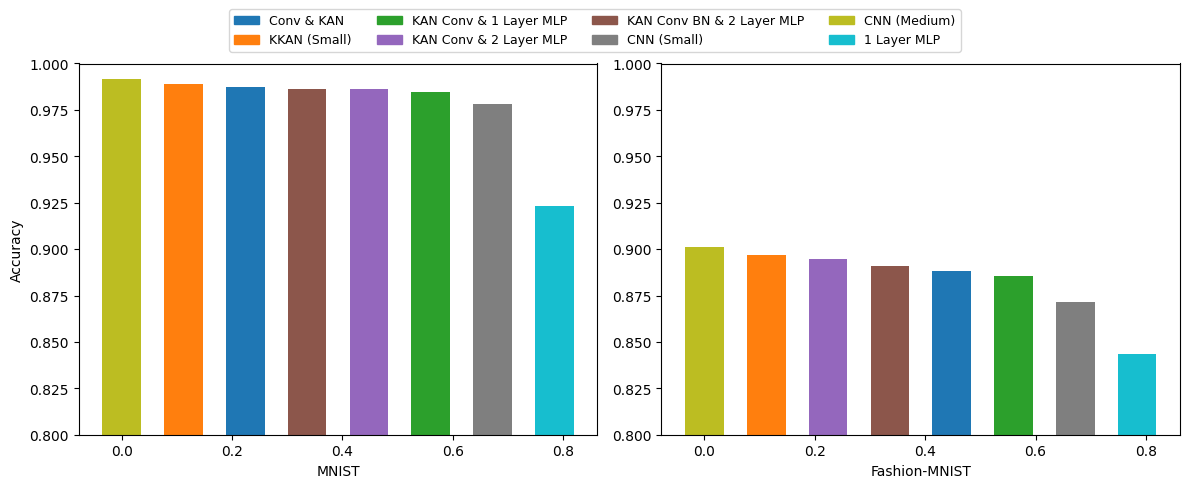

In [ ]:
# Datos de ejemplo
modelos = models_name_all_fashion
datasets = ['MNIST', 'Fashion-MNIST']

# Datos de precisión
accuracy_data = {
    'MNIST': test_accuracy_models_MNIST,
    'Fashion-MNIST': test_accuracy_models_fashion,
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Ajustar tamaño para más modelos

bar_width = 0.07  # Reducir el ancho de las barras

# Generar un mapa de colores para cada modelo
color_map = plt.get_cmap('tab10')(np.linspace(0, 1, len(modelos)))

for i, (dataset, ax) in enumerate(zip(datasets, axes)):
    # Organizar los modelos de acuerdo a la precisión, de mayor a menor
    sorted_indices = np.argsort(accuracy_data[dataset])[::-1]
    sorted_modelos = [modelos[idx] for idx in sorted_indices]
    sorted_accuracy = [accuracy_data[dataset][idx] for idx in sorted_indices]
    sorted_colors = [color_map[idx] for idx in sorted_indices]

    index = np.arange(len(sorted_modelos)) * (bar_width * len(sorted_modelos) * 0.2)  # Ajustar la separación

    # Crear barras para cada modelo en este dataset específico
    for j in range(len(sorted_modelos)):
        ax.bar(index[j], sorted_accuracy[j], bar_width, color=sorted_colors[j], label=sorted_modelos[j] if i == 0 else "")

    ax.set_xlabel(dataset, fontsize=10)
    # ax.set_xticks(index)
    # ax.set_xticklabels(sorted_modelos, fontsize=10, rotation=90)  # Rotar etiquetas para mejor legibilidad
    ax.set_ylim(0.8, 1)

    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=10)

# Añadir leyenda con una sola instancia por etiqueta
handles = [plt.Rectangle((0,0),1,1, color=color_map[i]) for i in range(len(modelos))]
fig.legend(handles, modelos, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=9)

# Ajustar el layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Mostrar el gráfico
plt.show()

In [ ]:
plot_roc_one_vs_rest_all_models(models, test_loader,n_classes=10,device=device)

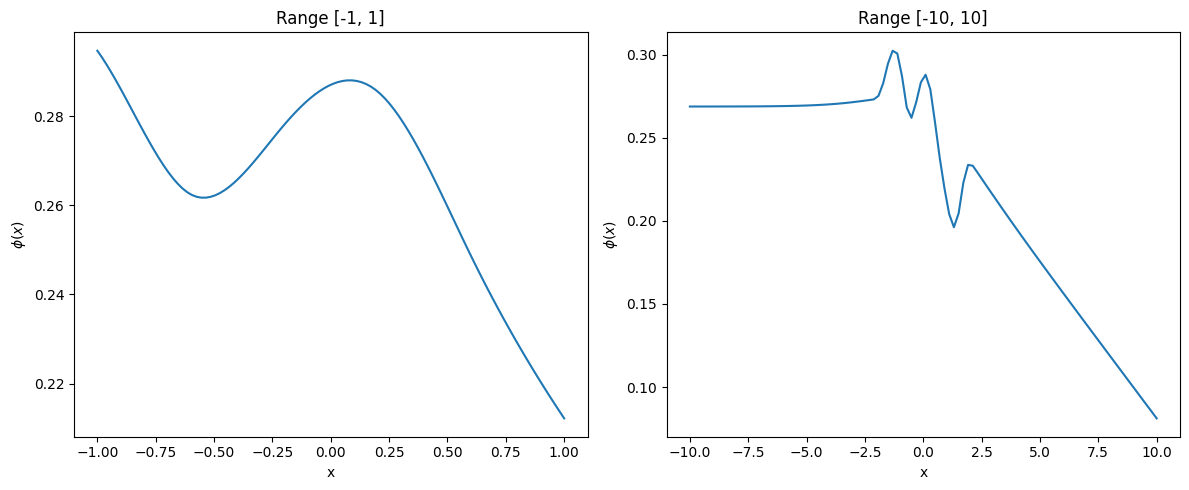

In [ ]:
# Initialize the figure
plt.figure(figsize=(12, 5))

# First plot: x in range [-1, 1]
x1 = np.linspace(-1, 1, 100)
y1 = []

for i in x1:
    tensor_x = torch.zeros((1, 1, 28, 28)).to(device)
    tensor_x[0, 0, 0, 0] = i
    post_conv = models[2].conv1(tensor_x)
    y_aux = post_conv[0, 0, 0, 0].item()
    y1.append(y_aux)

# Plot the first set of results
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(x1, y1)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('Range [-1, 1]')

# Second plot: x in range [-10, 10]
x2 = np.linspace(-10, 10, 100)
y2 = []

for i in x2:
    tensor_x = torch.zeros((1, 1, 28, 28)).to(device)
    tensor_x[0, 0, 0, 0] = i
    post_conv = models[2].conv1(tensor_x)
    y_aux = post_conv[0, 0, 0, 0].item()
    y2.append(y_aux)

# Plot the second set of results
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(x2, y2)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('Range [-10, 10]')

# Show the plots
plt.tight_layout()
plt.show()

